#### Importamos las librerias necesarias

In [1]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm
import itertools
import matplotlib.pyplot as plt
import numpy as np

#### Creamos nuestras variables globales

In [2]:
global PROHIBIDAS
PROHIBIDAS = [""]
global ARCHIVO
ARCHIVO = "comments.csv"
global DATASET
DATASET = pd.read_csv(ARCHIVO)


In [3]:
#Funcion para obtener los indices de las reviews positivas y negativas
def Probabilidades_Iniciales(dataset):
    Numero_Reviews_Positivas = 0
    Numero_Reviews_Negativas = 0
    for i in range(len(dataset)):
        if dataset["comment"].iloc[i] != "":
            if dataset["rating"].iloc[i] == 1:
                Numero_Reviews_Positivas += 1
            if dataset["rating"].iloc[i] == 0:
                Numero_Reviews_Negativas += 1
    Probabilaidad_Negativa = Numero_Reviews_Negativas/len(dataset)
    Probabilidad_Positiva = Numero_Reviews_Positivas/len(dataset)
    return Probabilaidad_Negativa, Probabilidad_Positiva


In [4]:
def Vectores_Palabras(dataset):
    Palabras_Positivas = []
    Palabras_Negativas = []
    Largo = len(dataset)
    for i in range(Largo):
        if dataset["comment"].iloc[i] != "": 
            if dataset["rating"].iloc[i] == 1 : 
                Palabras_Positivas.append(dataset["comment"].iloc[i])
            if dataset["rating"].iloc[i] == 0: 
                Palabras_Negativas.append(dataset["comment"].iloc[i])
    return Palabras_Positivas, Palabras_Negativas

In [5]:
def Filtar_Palabras(Palabras):
    Palabras_Filtradas = []
    for review in Palabras:
        if isinstance(review, str):  # Check if the element is a string
            tokens = word_tokenize(review)
            stopwords_ingles = set(stopwords.words('spanish'))
            Palabras_Filtradas.extend([Palabra.lower() for Palabra in tokens
                                        if Palabra.isalpha() and Palabra.lower()
                                        not in stopwords_ingles and Palabra.lower() not in PROHIBIDAS])
    return Palabras_Filtradas


In [6]:
def Probabilidad_Palabra(Palabra, Review):
    Probabilidad_Palabra = (Review.count(Palabra)+1) / len(Review)
    return Probabilidad_Palabra

In [7]:
#Funcion para obtener la frecuencia de las palabras en las reviews
def Frecuencia_Palabras(Palabras):
    Frecuencia = Counter(Palabras)
    print(Frecuencia.most_common(10))
    return Frecuencia


In [8]:
def Naive_Bayes(Review, Palabras):
    Probabilidad = 1
    Probabilidades = []
    # Ensure Review is a string
    if not isinstance(Review, str):
        Review = str(Review)
    Review_Filtrada = Filtar_Palabras([Review])
    Review_Token = word_tokenize(Review)
    for Palabra in Review_Token:
        if Palabra not in Palabras:
            Probabilidad = Probabilidad * 1.
        else:
            Probabilidad = Probabilidad + Probabilidad_Palabra(Palabra, Palabras)
    return Probabilidad

In [9]:
def Pruebas(Palabras_Positivas, Palabras_Negativas,Review_Prueba,dataset):
    Probabilidad_Inicial_Negativa, Probabilidad_Inicial_Positiva = Probabilidades_Iniciales(dataset)
    Probabilidad_De_Ser_Positiva = Naive_Bayes(Review_Prueba, Palabras_Positivas)
    Probabilidad_De_Ser_Positiva *= Probabilidad_Inicial_Positiva
    Probabilidad_De_Ser_Negativa = Naive_Bayes(Review_Prueba, Palabras_Negativas)
    Probabilidad_De_Ser_Negativa *= Probabilidad_Inicial_Negativa
    Resultado = 0
    if Probabilidad_De_Ser_Positiva > Probabilidad_De_Ser_Negativa:
        Resultado = 1
    if Probabilidad_De_Ser_Positiva and Probabilidad_De_Ser_Negativa == 0:
        Resultado = -1
    if Resultado == 0:
        print(Probabilidad_De_Ser_Negativa, Probabilidad_De_Ser_Positiva)
    return Resultado

In [10]:
def Matriz_Confusion(dataset, Palabras_Positivas, Palabras_Negativas):
    y_true = []
    y_pred = []
    for i in range(len(dataset)):
        if dataset["comment"].iloc[i] != "":
            if dataset["rating"].iloc[i] == 1:
                y_true.append(1)
            if dataset["rating"].iloc[i] == 0:
                y_true.append(0)
    for i in range(len(dataset)):
        if Pruebas(Palabras_Positivas, Palabras_Negativas, dataset["comment"].iloc[i],dataset) == 1:
            y_pred.append(1)
        if Pruebas(Palabras_Positivas, Palabras_Negativas, dataset["comment"].iloc[i],dataset) == 0:
            y_pred.append(0)
            print("Comentario")
            print(dataset["comment"].iloc[i] + "\n")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    Presicion = (tn+tp)/(tn+fp+fn+tp)
    FalsosPositivos = fp/(tn+fp)
    FalsosNegativos = fn/(fn+tp)
    Error = 1-Presicion
    AcertividadPositiva = tp/(fp+tp)
    if tn + fn == 0:
        AcertividadNegativa = 0 # or 1, depending on your preference
    else:
        AcertividadNegativa = tn / (tn + fn)

    return Presicion, FalsosPositivos, FalsosNegativos, Error, AcertividadPositiva, AcertividadNegativa


In [11]:
def main():
    # Dividir el conjunto de datos en entrenamiento y prueba (70% entrenamiento, 30% prueba)
    df_train, df_test = train_test_split(DATASET, test_size=0.2, random_state=0)
    #print(df_test.head(100))
    #print(df_train.head(100))

    # Obtener palabras de los conjuntos de entrenamiento y prueba
    Palabras_Positivas_train, Palabras_Negativas_train = Vectores_Palabras(df_train)
    #Palabras_Positivas_test, Palabras_Negativas_test = Vectores_Palabras(df_test)

    # Filtrar palabras
    Palabras_Positivas_train = Filtar_Palabras(Palabras_Positivas_train)
    Palabras_Negativas_train = Filtar_Palabras(Palabras_Negativas_train)

    #print('Cantidad de palabras positivas en el conjunto de entrenamiento:', len(Palabras_Positivas_train))
    #print('Cantidad de palabras negativas en el conjunto de entrenamiento:', len(Palabras_Negativas_train))
    #print('Cantidad de palabras positivas en el conjunto de prueba:', len(Palabras_Positivas_test))
    #print('Cantidad de palabras negativas en el conjunto de prueba:', len(Palabras_Negativas_test))

    #print("Frecuencia de las palabras positivas y negativas en el conjunto de entrenamiento :)")
    Frecuencia_Palabras(Palabras_Positivas_train)
    Frecuencia_Palabras(Palabras_Negativas_train)
    print()

    print("Precision Global, Falsos Positivos, Falsos Negativos, Error Global, Acertividad Positiva, Acertividad Negativa\n")
    print(Matriz_Confusion(df_test, Palabras_Positivas_train, Palabras_Negativas_train))


In [12]:
main()

[('excelente', 333), ('bien', 324), ('producto', 310), ('calidad', 272), ('buena', 247), ('precio', 234), ('buen', 220), ('si', 153), ('fácil', 144), ('recomiendo', 126)]
[('calidad', 33), ('producto', 32), ('agua', 26), ('bien', 25), ('mala', 22), ('si', 22), ('solo', 21), ('malo', 18), ('plástico', 15), ('verdad', 13)]

Precision Global, Falsos Positivos, Falsos Negativos, Error Global, Acertividad Positiva, Acertividad Negativa

(0.8627450980392157, 1.0, 0.0, 0.13725490196078427, 0.8627450980392157, 0)


#### Modelo SVM

In [13]:
DATASET.head()

,rating,comment
0,1,Lo compre hace una semana cuando estaba con 10...
1,1,Lo compré apenas el 23 mayo 23 me encantó el p...
2,1,El producto asta el momento me a funcionado bi...
3,1,Me pareció excelente calidad precio por ahora ...
4,1,"8gb de ram + 3gb virtuales, 256gb de almacenam..."


#### Divimos el dataset en entrenamiento y prueba

In [14]:
#Obtenos y de la columna rating
y = DATASET['rating']
#Obtenemos X de la columna comment
X = DATASET

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

PalabrasP_train,PalabrasN_train = Vectores_Palabras(X_train)
PalabrasP_test,PalabrasN_test = Vectores_Palabras(X_test)

PalabrasP_train = Filtar_Palabras(PalabrasP_train)
PalabrasN_train = Filtar_Palabras(PalabrasN_train)

PalabrasP_test = Filtar_Palabras(PalabrasP_test)
PalabrasN_test = Filtar_Palabras(PalabrasN_test)

NumPalabrasP = Frecuencia_Palabras(PalabrasP_train)
#NumPalabrasN = Frecuencia_Palabras(PalabrasN_train)

# Por cada review obtenemos el numero de palabras y las dividimos entre de palabras positivas o negativas
X_trainNP = []
for i in range(len(X_train)):
    if X_train['rating'].iloc[i] == 1:
        X_trainNP.append(len(Filtar_Palabras([X_train['comment'].iloc[i]]))/len(PalabrasP_train))
    else:
        X_trainNP.append(len(Filtar_Palabras([X_train['comment'].iloc[i]]))/len(PalabrasN_train))

X_trainNP = pd.DataFrame(X_trainNP)
#X_trainNP

X_testNP = []
for i in range(len(X_test)):
    if X_test['rating'].iloc[i] == 1:
        X_testNP.append(len(Filtar_Palabras([X_test['comment'].iloc[i]]))/len(PalabrasP_test))
    else:
        X_testNP.append(len(Filtar_Palabras([X_test['comment'].iloc[i]]))/len(PalabrasN_test))

X_testNP = pd.DataFrame(X_testNP)
X_testNP

#Aplicamos el modelo de SVM
clf = svm.SVC(kernel = 'rbf')
clf.fit(X_trainNP, y_train)

[('excelente', 333), ('bien', 324), ('producto', 310), ('calidad', 272), ('buena', 247), ('precio', 234), ('buen', 220), ('si', 153), ('fácil', 144), ('recomiendo', 126)]


SVC()

In [15]:
y_pred = clf.predict(X_testNP)
y_pred [0:5]

array([1, 1, 1, 1, 0], dtype=int64)

#### Matriz de Confusion

In [16]:
def plot_Confusion_Matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusion normalizada")
    else:
        print('Matriz de confusion sin normalizar')
    
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [17]:
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1])
np.set_printoptions(precision=2)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.86      0.55        56
           1       0.97      0.80      0.88       352

    accuracy                           0.80       408
   macro avg       0.69      0.83      0.71       408
weighted avg       0.89      0.80      0.83       408



Matriz de confusion sin normalizar
[[ 48   8]
 [ 72 280]]


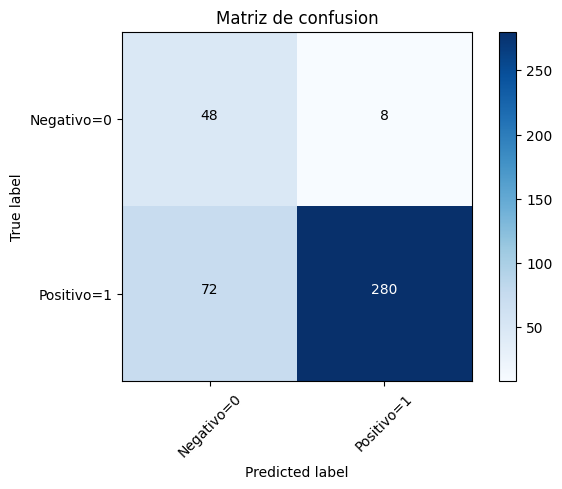

In [18]:
plt.figure()
plot_Confusion_Matrix(cnf_matrix, classes=['Negativo=0', 'Positivo=1'], normalize=False, title='Matriz de confusion')

##### Precision Global, Error Global, Falsos Positivo, Falsos Negativo, Acertividad Positiva y Negativa

In [30]:
# Calculamos la precision y error global
from sklearn.metrics import f1_score
PrecisionG = f1_score(y_test, y_pred, average='weighted')
print("Precisión Global: ", PrecisionG)
Error = 1 - PrecisionG
print("Error Global: ", Error)

# Calculamos los falsos positivos y falsos negativos
FP = cnf_matrix[0,1]/(cnf_matrix[0,1] + cnf_matrix[0,0])
FN = cnf_matrix[1,0]/(cnf_matrix[1,0] + cnf_matrix[1,1])
print("Falsos Positivos: ", FP)
print("Falsos Negativos: ", FN)

# Asertividad Positiva y Asertividad Negativa
AsertividadP = (cnf_matrix[0,0] + cnf_matrix[1,1])/(cnf_matrix[0,0] + cnf_matrix[1,1] + cnf_matrix[0,1] + cnf_matrix[1,0])
AsertividadN = cnf_matrix[1,1]/(cnf_matrix[1,1] + cnf_matrix[0,1])
print("Asertividad Positiva: ", AsertividadP)
print("Asertividad Negativa: ", AsertividadN)


Precisión Global:  0.8297682709447416
Error Global:  0.1702317290552584
Falsos Positivos:  0.14285714285714285
Falsos Negativos:  0.20454545454545456
Asertividad Positiva:  0.803921568627451
Asertividad Negativa:  0.9722222222222222
